In [11]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import zipfile
import cv2
import os
import shutil
import glob
import pandas as pd
import numpy as np
import random
from google.colab import drive
from tqdm import tqdm
from imutils import paths
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, ReLU
import warnings
warnings.filterwarnings('ignore')
tf.__version__

'2.17.1'

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
# train/test/validation split and save

# GENARATOR_IMAGE_DIR = "/content/drive/MyDrive/Chamara-alzheimer-disease-classifier-ViT/dataset-100-samples-each"
# CLASSWISE_IMAGE_DIR = "/content/drive/MyDrive/Chamara-alzheimer-disease-classifier-ViT/dataset-100-samples-splitted"
GENARATOR_IMAGE_DIR = "/content/PBC_dataset_normal_DIB"
CLASSWISE_IMAGE_DIR = "/content/PBC_dataset_splitted"

def save_images_generator_format():
	# derive the training, validation, and testing directories
	TRAIN_PATH = os.path.sep.join([CLASSWISE_IMAGE_DIR, "train"])
	VAL_PATH = os.path.sep.join([CLASSWISE_IMAGE_DIR, "val"])
	TEST_PATH = os.path.sep.join([CLASSWISE_IMAGE_DIR, "test"])

	TRAIN_SPLIT = 0.8
	VAL_SPLIT = 0.1

	totalTrain = len(list(paths.list_images(TRAIN_PATH)))
	totalVal = len(list(paths.list_images(VAL_PATH)))
	totalTest = len(list(paths.list_images(TEST_PATH)))

	# grab the paths to all input images in the original input directory
	# and shuffle them
	imagePaths = list(paths.list_images(GENARATOR_IMAGE_DIR))
	random.seed(42)
	random.shuffle(imagePaths)
	# compute the training and testing split
	i = int(len(imagePaths) * TRAIN_SPLIT)
	trainPaths = imagePaths[:i]
	testPaths = imagePaths[i:]
	# using part of the training data for validation
	i = int(len(trainPaths) * VAL_SPLIT)
	valPaths = trainPaths[:i]
	trainPaths = trainPaths[i:]
	# define the datasets
	datasets = [
		("training", trainPaths, TRAIN_PATH),
		("validation", valPaths, VAL_PATH),
		("testing", testPaths, TEST_PATH)
	]
	# loop over the datasets
	for (dType, imagePaths, baseOutput) in datasets:
		# show which data split we are creating
		print("[INFO] building '{}' split".format(dType))
		# if the output base output directory does not exist, create it
		if not os.path.exists(baseOutput):
			print("[INFO] 'creating {}' directory".format(baseOutput))
			os.makedirs(baseOutput)
		# loop over the input image paths
		for inputPath in imagePaths:
			# extract the filename of the input image along with its
			# corresponding class label
			filename = inputPath.split(os.path.sep)[-1]
			label = inputPath.split(os.path.sep)[-2].replace(GENARATOR_IMAGE_DIR, '')
			# build the path to the label directory
			labelPath = os.path.sep.join([baseOutput, label])
			# if the label output directory does not exist, create it
			if not os.path.exists(labelPath):
				print("[INFO] 'creating {}' directory".format(labelPath))
				os.makedirs(labelPath)
			# construct the path to the destination image and then copy
			# the image itself
			p = os.path.sep.join([labelPath, filename])
			shutil.copy2(inputPath, p)

In [4]:
# 1. extract the zip file to Google colab instance
ZIP_FILE_DIR = "/content/drive/MyDrive/Chamara-alzheimer-disease-classifier-ViT/PBC_dataset_normal_DIB.zip"

zip_object = zipfile.ZipFile(file=ZIP_FILE_DIR, mode='r')
zip_object.extractall('./')
zip_object.close()

In [5]:
# 2. remove the platelet class from dataset
import os
import shutil

REMOVE_DIR = "/content/PBC_dataset_normal_DIB/platelet"

if os.path.exists(REMOVE_DIR):
    shutil.rmtree(REMOVE_DIR)

In [6]:
# 3. split the data to train/test/val
save_images_generator_format()

[INFO] building 'training' split
[INFO] 'creating /content/PBC_dataset_splitted/train' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/basophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/eosinophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/erythroblast' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/neutrophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/monocyte' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/ig' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/lymphocyte' directory
[INFO] building 'validation' split
[INFO] 'creating /content/PBC_dataset_splitted/val' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/ig' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/erythroblast' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/monocyte' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/eosinophil' directory
[INFO] 

# ViT Pipeline

In [12]:
from datasets import load_dataset
from transformers import AutoImageProcessor #-> like Tokenizer
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
import evaluate
import numpy as np
from transformers import AutoModelForImageClassification
import torch
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## 1. load dataset as a huggigface dataset

In [ ]:
dataset = load_dataset("imagefolder", data_dir=CLASSWISE_IMAGE_DIR)

Resolving data files:   0%|          | 0/10616 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1179 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2949 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset = dataset.shuffle()

In [ ]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 10616
})

In [ ]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=360x363>,
 'label': 1}

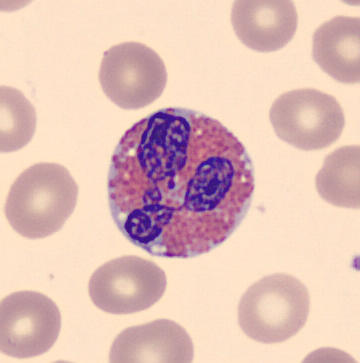

In [ ]:
dataset['train'][0]['image']

In [ ]:
dataset['train'][0]['label']

1

In [ ]:
labels = dataset['train'].features['label'].names
print(len(labels))
labels

7


['basophil',
 'eosinophil',
 'erythroblast',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil']

In [ ]:
labels = dataset['train'].features['label'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6}
{0: 'basophil', 1: 'eosinophil', 2: 'erythroblast', 3: 'ig', 4: 'lymphocyte', 5: 'monocyte', 6: 'neutrophil'}


# 2. Image pre-processing

In [ ]:
model_ckpt = "google/vit-base-patch16-224-in21k"
# model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size
        else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch

dataset = dataset.with_transform(transforms)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

## 3. Vision Transformer (ViT) Fine Tuning for Image Classification

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)

print(model)

cuda


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## 4. Model Training

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 5

args = TrainingArguments(
    output_dir="train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.578200,0.207964,0.960326
2,0.199700,0.173815,0.957613
3,0.144400,0.142029,0.962699
4,0.116300,0.147748,0.960326
5,0.098200,0.120396,0.967107


TrainOutput(global_step=3320, training_loss=0.1984276633664786, metrics={'train_runtime': 2155.3616, 'train_samples_per_second': 24.627, 'train_steps_per_second': 1.54, 'total_flos': 4.1134591386479e+18, 'train_loss': 0.1984276633664786, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

MODEL_ARTIFACT_NAME = 'ViT_base_model_finetuned'
trainer.save_model(MODEL_ARTIFACT_NAME)

## 5. Model Evaluation - Classification Report and Confusion Matrix

              precision    recall  f1-score   support

    basophil       0.99      0.98      0.99       234
  eosinophil       0.99      0.99      0.99       597
erythroblast       0.96      0.98      0.97       306
          ig       0.94      0.95      0.95       612
  lymphocyte       0.99      0.97      0.98       235
    monocyte       0.97      0.95      0.96       305
  neutrophil       0.97      0.96      0.96       660

    accuracy                           0.97      2949
   macro avg       0.97      0.97      0.97      2949
weighted avg       0.97      0.97      0.97      2949



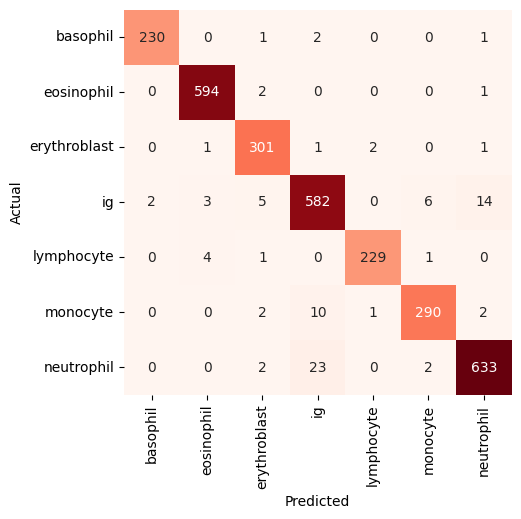

In [ ]:
logits = trainer.predict(dataset['test'])
logits = logits.predictions

y_pred = np.argmax(logits, axis=1)
y_true = [x['label'] for x in dataset['test']]

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## save model to G-drive

In [ ]:
GDRIVE_DIR = f'/content/drive/MyDrive/Chamara-alzheimer-disease-classifier-ViT/models/{MODEL_ARTIFACT_NAME}'
!scp -r ViT_base_model_finetuned '/content/drive/MyDrive/Chamara-alzheimer-disease-classifier-ViT/models/ViT_base_model_finetuned'

# Inference

In [8]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch

# Load the model and image processor from the local directory
local_directory = '/content/drive/MyDrive/Chamara-alzheimer-disease-classifier-ViT/models/ViT_base_model_finetuned'
image_processor = AutoImageProcessor.from_pretrained(local_directory, use_fast=True)
model = AutoModelForImageClassification.from_pretrained(local_directory, local_files_only=True)

In [10]:
# Load a sample image from the local directory
# image_path = '/content/PBC_dataset_splitted/test/monocyte/MO_105547.jpg'
image_path = '/content/PBC_dataset_splitted/test/eosinophil/EO_112884.jpg'

image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

# Preprocess the image
inputs = image_processor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted label
predicted_label_idx = torch.argmax(outputs.logits, dim=1).item()
predicted_label = model.config.id2label[predicted_label_idx]

# Print the result
print(f"Predicted label: {predicted_label}")

Predicted label: eosinophil
